# Final Simulation Model

### Base model functionality
- Add the following properties to the Results (they should be printed when calling `print(results)`): Total cost (system cost + operating cost for 10 years), Self-consumption (PV yield used to charge trucks), load-cycles (total battery charge as a fraction of battery capacity)
- change the defaults to the following values:  
``` 
    default Battery SoC to zero
    pv_cost_pkWp = 1500
    battery_kWh: float
    battery_cost_pkWh= 300
    grid_tarif_cpkWh = 50
    grid_feedin_cpkWh = 7.06
```
- correct the `operating_cost` method to return €/a
-  `simulate()` a fleet of Etruck fleet of 5 trucks with "Workday" and 2 Trucks with "Worknight" schedule with different PV kWp and Battery kWh Sizes.
1. Simulate different Models (kWp and kWh sizes) and discuss their resulting differences: Compare a system without any PV or Battery with a more cost effective system. The total system cost without PV or Battery should be in the range of 800.000 €/10a
2. Which system configuration achieves the lowest total cost?
3. Demonstrate the correctness of your results by plotting an interesting week and discussing the observed model behaviour. 

Demonstrating these functionalities in this Notebook is mandatory and will grant you 10/20 Points of the simulation exercise.  To pass this part, 10/20 are required. To increase your points, you can additionally implement any of the following bonus objectives:

### Bonus functionalities ~~~~~ after solution of Base model functionality ~~~~~


In [1]:
###~~~~~~~~~~~~~~~~~~~~~~~~
# Base model functionality
###~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
import pandas as pd
import Model as m
import matplotlib.pyplot as plt
###~~~~~~~~~~~~~~~~~~~~~~~~

# Result_pvb for simulate_pvb():
class Result_pvb:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 1500                    # was 1000
    battery_kWh: float                     # was float
    battery_cost_pkWh= 300                 # was 300
    grid_tarif_cpkWh = 50                  # was 0.19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp + self.battery_cost_pkWh*self.battery_kWh
    
    #> Operating cost per annum? >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption from "PV to Grid" to "PV to Truck" >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 

    #> Load-cycles battery charge >
    @property
    def load_cycles(self):
        total_charge = self.total_battery_charge
        return total_charge / self.battery_kWh  
    
    #> extension from Übung 3:
    @property
    def total_battery_charge(self):
        return self.energy_balance["PV to Battery"].sum()

    @property
    def total_battery_discharge(self):
        return self.energy_balance["Battery to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Battery to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()

    def check_battery_balance(self):
        total_charge = self.total_battery_charge
        total_discharge = self.total_battery_discharge
        print(f"Total Battery Charge: {total_charge:.2f} kWh")
        print(f"Total Battery Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Battery Charge = Battery Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Battery charge > Battery Discharge___ <<<<\n")
        else:
            print(">>>> ___Battery charge < Battery Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    #>>>>> until here
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])

    #> extension from Übung 3:    
        self.check_battery_balance()
        self.check_energy_balance()
    #>>>>> until here

    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a'                                 # added
        string += f'\n{self.load_cycles=:.0f}kwh\n'                                 # added
        return string
    
#> 1) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#> simulation pv, battery and grid included >
def simulate_pvb(
        csv_dpath = "D:\Maria\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                  # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

In [2]:
# Result_ for simulate_pv(), modifying battery enegy balance to grid energy balance:
class Result_:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 1500                    # was 1000
    grid_tarif_cpkWh = 50                  # was 0,19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp 
    
    #> Operating cost (€/a) >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption PV to Truck (was PV to Grid) >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 
    
    @property
    def total_grid_charge(self):
        return self.energy_balance["PV to Grid"].sum()

    @property
    def total_grid_discharge(self):
        return self.energy_balance["Grid to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()
    
    def check_grid_balance(self):
        total_charge = self.total_grid_charge
        total_discharge = self.total_grid_discharge
        print(f"Total Grid Charge: {total_charge:.2f} kWh")
        print(f"Total Grid Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Grid Charge = Grid Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Grid charge > Grid Discharge___ <<<<\n")
        else:
            print(">>>> ___Grid charge < Grid Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])
        
        self.check_grid_balance()
        self.check_energy_balance()
        
    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a\n'                                 # added
        return string


#> 2) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#> simulation pv and grid, battery excluded >
def simulate_pv(
        csv_dpath = "D:\Maria\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_grid_kWh[h] = dispatchable_PV 
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_()

    results.energy_balance = energy_balance
    results.states = states
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results


In [3]:
# a fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

In [4]:
# battery_kWh = b_kWh, pv_kWp = pv_kWo 
b_kWh = 1500  #  1500?
pv_kWo = 198  #  from 199 operating cost takes negative values

# with pv and battery:
results01_pvb = simulate_pvb(trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=pv_kWo)
#print(results01_pvb)
#results01_pvb.visualize(("M", "M"))
print(results01_pvb.system_cost)
print(results01_pvb.operating_cost)
print(results01_pvb)


747000
141359.18221512507
Energy Flows: 
Grid                 11992.0
PV to Truck          40297.0
PV to Battery       100387.0
PV to Grid           64909.0
Battery to Truck    100387.0
Grid to Truck        11992.0
Driven             -153442.0
dtype: float64
PV Yield: 205593kWh/a
self.system_cost=747_000.0€
self.operating_cost=141_359.2€/a
self.emissions=3237.9kg/a
self.self_consumption=0.8kWh
self.total_cost=2_160_591.8€/10a
self.load_cycles=67kwh



***AnSWER***:
- Tuning pv_kWp is essential!

Energy Flows: 
Grid              23709.0
PV to Truck       77491.0
PV to Grid       166521.0
Grid to Truck     23709.0
Driven          -101189.0
dtype: float64
PV Yield: 244012kWh/a
self.system_cost=352_500.0€
self.operating_cost=9_798.3€/a
self.emissions=6401.3kg/a
self.self_consumption=0.7kWh
self.total_cost=450_482.7€/10a

Total Grid Charge: 166520.53 kWh
Total Grid Discharge: 23708.66 kWh
>>>> ___Grid charge > Grid Discharge___ <<<<

Total Energy Input: 101199.71 kWh
Total Energy Output from Trucks: 101189.36 kWh
>>>> ___Energy Input > Energy Output___ <<<<



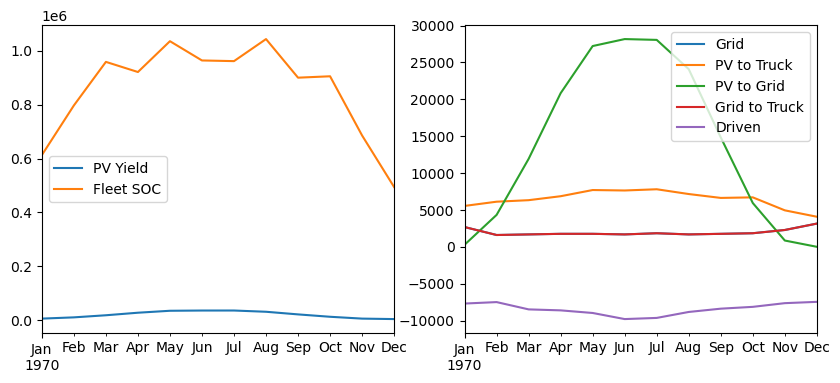

In [982]:
# without battery:
pv_kWo = 235 # must be btw. 230 and 235 operatin cost takes - values
results01_pv = simulate_pv(trucks=fleet_trucks, pv_kWp=pv_kWo)
print(results01_pv)
results01_pv.visualize(("M", "M"))

***AmSWER***: 
- Tuning pv_kWp is important.

C:\Users\Jura\AppData\Local\Temp\ipykernel_13196\1889337555.py:12: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  results01_pvb.energy_balance[results01_pvb.energy_balance.index.week==7].plot()
C:\Users\Jura\AppData\Local\Temp\ipykernel_13196\1889337555.py:14: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  results01_pv.energy_balance[results01_pv.energy_balance.index.week==7].plot()


<AxesSubplot: >

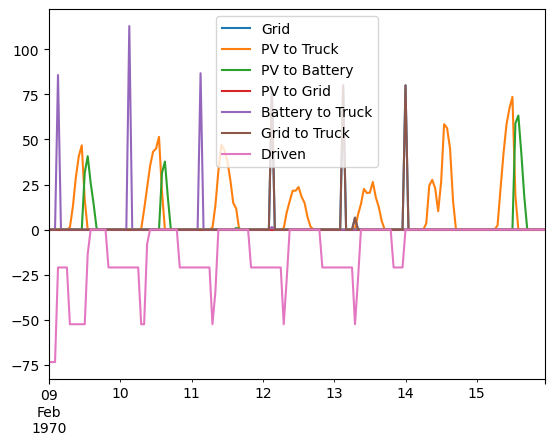

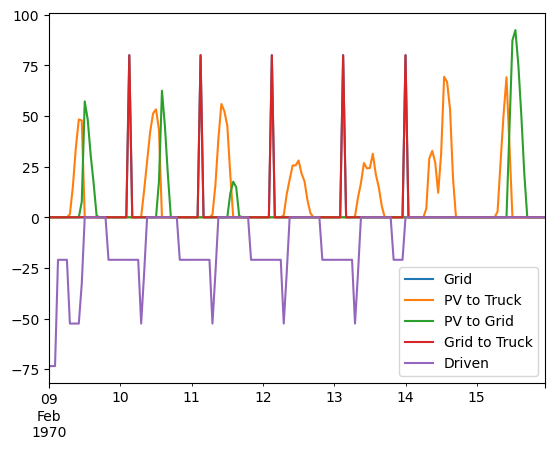

In [983]:
# The easy and straightforward way to obtain weekly profiles:
# results01_pvb.energy_balance[results01_pvb.energy_balance.index.week==x]
# whre x is the number of weeks (there are 52 in a year)

# By looking at the yearly profile, weeks in February, in August and in November seem to be very differing from one another.
# Therefore, the 3 interesting weeks to look at:
# 1) February 09 on ~ day 39 (week = 7)
# 2) August 17 on   ~ day 228 (week = 34)
# 3) November 02 on ~ day 305 (week = 45) 

# week 7 for pvb:
results01_pvb.energy_balance[results01_pvb.energy_balance.index.week==7].plot()
# week 7 for pv (no battery!!!):
results01_pv.energy_balance[results01_pv.energy_balance.index.week==7].plot()

***AnSWER***:
- Without battery, the PV to Grid and Grid to Truck are considerably increased, the Pv to Truck amount increses slightly. Grid is completely covered by Grid to Truck, meaning that all energy from Grid is transfered to Truck. Both, Pv to Grid and PV to Truck witness energy flows during the weekend.

C:\Users\Jura\AppData\Local\Temp\ipykernel_13196\199184788.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  results01_pvb.energy_balance[results01_pvb.energy_balance.index.week==34].plot()
C:\Users\Jura\AppData\Local\Temp\ipykernel_13196\199184788.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  results01_pv.energy_balance[results01_pv.energy_balance.index.week==34].plot()


<AxesSubplot: >

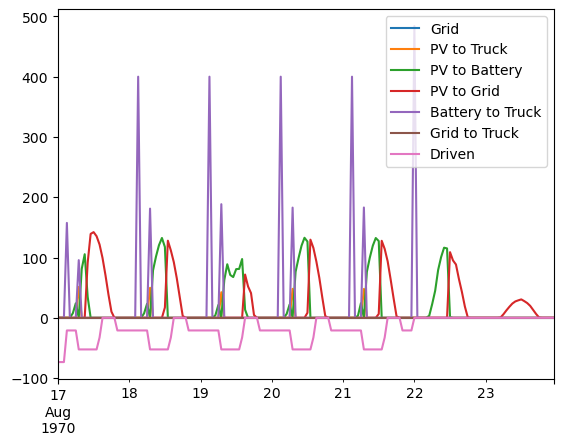

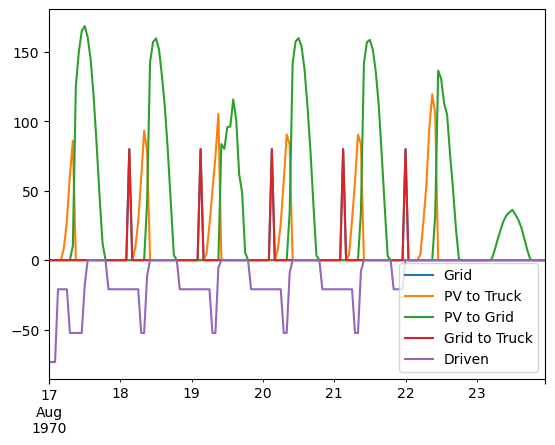

In [984]:
# week 34 for pvb:
results01_pvb.energy_balance[results01_pvb.energy_balance.index.week==34].plot()
# week 34 for pv (no battery!!!):
results01_pv.energy_balance[results01_pv.energy_balance.index.week==34].plot()

***AnSWERs***:
- In general, the same phenomenon can be observed as in the case of February's selected week with an incresing differentiation between PV to Truck energy flow. Here the rise is more pronounced than in the February example. 
- The model with battery prefers the energy flows Pv to Battery and PV to Grid to PV to Truck. Therefore  the energy flows between PV to Battery and PV to Grid are 2-3 times more than the energy transfer from PV to Truck. Once the battery is out, this situation changes drastically, incersing the energy transfer from PV to Truck and to Grid as well.
- Consequently, an other significant change between the models with and without battery is the fact that the energy transfer from Grid to Truck accordingly (incresing PV to Grid -> incresing Grid to Truck) increases. 

C:\Users\Jura\AppData\Local\Temp\ipykernel_13196\2546172722.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  results01_pvb.energy_balance[results01_pvb.energy_balance.index.week==45].plot()
C:\Users\Jura\AppData\Local\Temp\ipykernel_13196\2546172722.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  results01_pv.energy_balance[results01_pv.energy_balance.index.week==45].plot()


<AxesSubplot: >

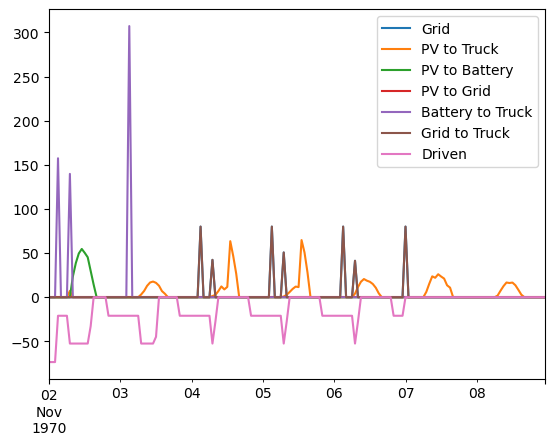

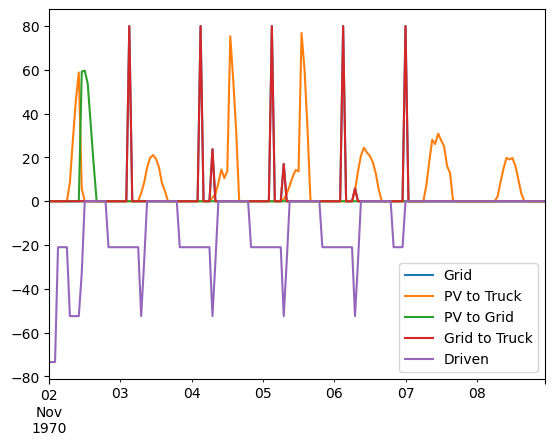

In [985]:
# week 45 for pvb:
results01_pvb.energy_balance[results01_pvb.energy_balance.index.week==45].plot()
# week 45 for pv (no battery!!!):
results01_pv.energy_balance[results01_pv.energy_balance.index.week==45].plot()

***AnSWER***:
- On 02.11 Pv to Battery flow stops -> on 03.11 the Battery to Truck flow stops. Same as above (February and August weeks): after decoupling the Battery, PV to Truck, Grid and Grid to Truck (Grid is not visible becasue Grid to Truck covers it) increase.


### Bonus functionalities

- **Sunk cost (1 pt)**: Assume a PV system with 192 kWp is already installed. The only question is, how big the battery should be to minimize the total cost. Set the PV price to zero and demonstrate a feasible Battery sizing.
- **PV Interface (1 pts)**: Introduce a function that takes three parameters: a `csv_path`, a `csv_kWp` and a `target_kWp`. The function should return a numpy array, whose values are scaled to match the `target_kWp/csv_kWp` ratio. The simulation should use this function to obtain the pv profile. Compare the system results for the existing `PV_1kWp.csv` with another PV system like the provided `PV_3kWp_EW.csv` and `3kWp_30south.csv`
- **Randomness (1 pts)**: Introduce random deviations into the hourly km driven by using the average km default as the mean to a standard or triangle distribution of varying width. Discuss it's effect on the model
- **More Schedules (3 pts)**: Introduce 4 new schedules and discuss their impact on the model by comparing the base model to a fleet of 7 trucks with any of these schedules. What would be an optimal fleet composition?
    - `daytime`: like workday, but also on weekends
    - `nighttime`: like worknight, but also on weekends
    - `evening`: offsite driving every weekday, except between 16-19 pm
    - `lunchbreak`: offsite driving every day between 6am - 19pm, except for a 12-2 lunch break
- **Sensitivity Analysis (4 pts)**: Vary the default parameters above in a structured way (e.g. by iterating over a range of possibilites, recording the results) and collect the main results in a new dataframe and discuss the influence of the parameters on the model by plotting the resulting total cost on the y-axis and the parameter variation on the x-axis.
- **Monthly Schedule (6 pts)**: Add a parameter `monthly_km` to the `simulate()` function, that is a list of monthly km targets. Convert this info in an average km goal per truck per hour per month and use this list to dynamically set the km driven depending on the month. Compare these two schedules for the base truck fleet and one with an optimizied schedule:
    - `[57800, 51850, 56100,	53550,	55250,	54400,	54400,	52700,	51000,	57800,	55250,	57800]`
    - `[36750,	39000,	70100,	69000,	78700,	65100,	75200,	66000,	69400,	64500,	60000,	35200]`
    

**###~~~~~~~~~~~~~~~~~~~~~###**
**Bonus functionalities**
**###~~~~~~~~~~~~~~~~~~~~~###**

### Sunk cost

In [1000]:
import Model as m
import numpy as np
import matplotlib.pyplot as plt

In [1001]:
# setting pv cost to 0:
class Result_pvbc:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 0                       # was 1500
    battery_kWh: float                     # was float
    battery_cost_pkWh= 300                 # was 300
    grid_tarif_cpkWh = 50                  # was 0,19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp + self.battery_cost_pkWh*self.battery_kWh
    
    #> Operating cost per annum? >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 

    #> Load-cycles battery charge >
    @property
    def load_cycles(self):
        total_charge = self.total_battery_charge
        return total_charge / self.battery_kWh  
    
    #> extension from Übung 3:
    @property
    def total_battery_charge(self):
        return self.energy_balance["PV to Battery"].sum()

    @property
    def total_battery_discharge(self):
        return self.energy_balance["Battery to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Battery to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()

    def check_battery_balance(self):
        total_charge = self.total_battery_charge
        total_discharge = self.total_battery_discharge
        print(f"Total Battery Charge: {total_charge:.2f} kWh")
        print(f"Total Battery Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Battery Charge = Battery Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Battery charge > Battery Discharge___ <<<<\n")
        else:
            print(">>>> ___Battery charge < Battery Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    #>>>>> until here
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])
        
    #> extension from Übung 3:    
        self.check_battery_balance()
        self.check_energy_balance()
    #>>>>> until here

    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a'                                 # added
        string += f'\n{self.load_cycles=:.0f}kwh\n'                                 # added
        return string

# assign Result_pvbc to simulate_pvbc()
def simulate_pvbc(
        csv_dpath = "D:\Maria\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                  # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvbc()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

# an array of sensible battery sizes to loop over:
batt_size = np.arange(500, 2600, 100)

# run the loop 
sunk_op = []
sunk_munk = []
for i in batt_size:
    sim_res = simulate_pvbc(trucks=fleet_trucks, battery_kWh=i, pv_kWp=197) # from 198 negative operating cost
    sunk_op.append(sim_res.operating_cost)
    sunk_munk.append(sim_res.total_cost)

print(f"Battery size reducing total cost to minimum requires battery performance of: {batt_size[np.argmin(sunk_munk)]} kWh, \nrevealing a operating cost of {round(sunk_op[np.argmin(sunk_munk)], 1)} €.")
print(f"Battery size reducing total cost to minimum requires battery performance of: {batt_size[np.argmin(sunk_munk)]} kWh, \nrevealing a total cost of {round(sunk_munk[np.argmin(sunk_munk)], 1)} €/10a.")

Battery size reducing total cost to minimum requires battery performance of: 500 kWh, 
revealing a operating cost of 2485.9 €.
Battery size reducing total cost to minimum requires battery performance of: 500 kWh, 
revealing a total cost of 174859.1 €/10a.


***AnSWER***: 
- Apparently, the lower the battery performance is, the lower the total cost is. In our case ~ since our first value for the battery was 500 kWh ~ it is a battery with 500 kWh performance that reduces the total cost (174859.1 €/10a) to the minimum.
- Tuning pv_kWp is crucial.

### PV Interface

Energy Flows: 
Grid                 10190.0
PV to Truck          32954.0
PV to Battery       100352.0
PV to Grid           71249.0
Battery to Truck    100352.0
Grid to Truck        10190.0
Driven             -143682.0
dtype: float64
PV Yield: 204554kWh/a
self.system_cost=745_500.0€
self.operating_cost=6_475.8€/a
self.emissions=2751.3kg/a
self.self_consumption=0.8kWh
self.total_cost=810_257.9€/10a
self.load_cycles=67kwh

Total Battery Charge: 100351.77 kWh
Total Battery Discharge: 100351.77 kWh
>>>> ___Battery charge > Battery Discharge___ <<<<

Total Energy Input: 143495.37 kWh
Total Energy Output from Trucks: 143682.43 kWh
>>>> ___Energy Input < Energy Output___ <<<<

Energy Flows: 
Grid                 10152.0
PV to Truck          30806.0
PV to Battery       103182.0
PV to Grid           69722.0
Battery to Truck    103182.0
Grid to Truck        10152.0
Driven             -144032.0
dtype: float64
PV Yield: 203711kWh/a
self.system_cost=568_500.0€
self.operating_cost=15_367.7€/a
self.em

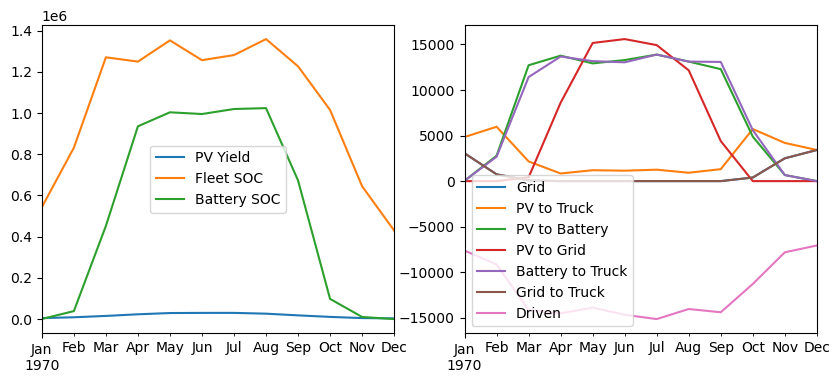

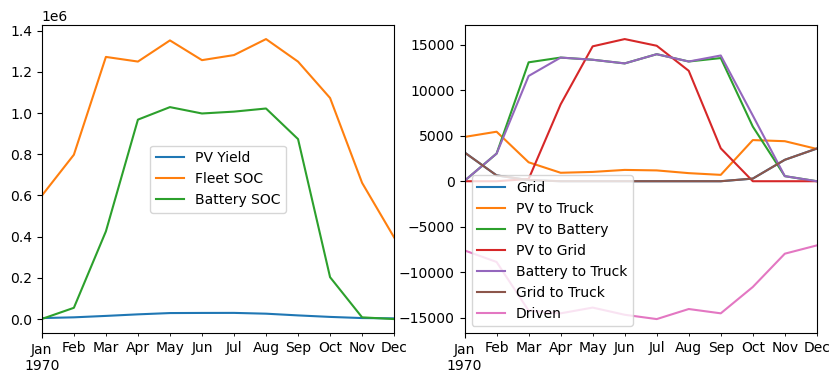

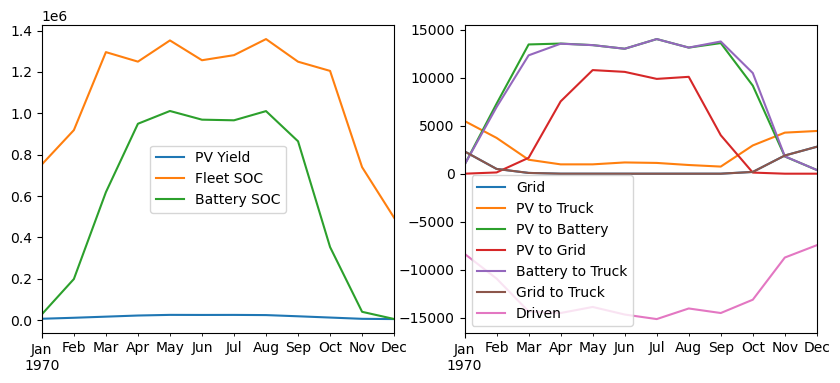

In [1018]:
# the function
def gimme_kWp(csv_path, csv_kWp, target_kWp):
    ratio_kWp=target_kWp/csv_kWp
    return (ratio_kWp*np.genfromtxt(csv_path))/1000 # to kWh

# use of gimme_kWp() 
def simulate_pvbp(
        csv_dpath = "D:\Maria\data\PV_1kWp.csv",
        start_day = 0, 
        hours = 8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        csv_kWp = 200, 
        battery_kWh = 2000,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = gimme_kWp(csv_path=csv_dpath, csv_kWp=csv_kWp, target_kWp=pv_kWp)  # pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                  # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

# before simulations, rename "3kWp_30south.csv" to "PV_3kWp_30south.csv"

# simulations
csv_kWp = 1
#target_kWp = varying
sim01 = simulate_pvbp(csv_dpath="D:\Maria\data\PV_1kWp.csv", trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=197, csv_kWp=csv_kWp)
sim02 = simulate_pvbp(csv_dpath="D:\Maria\data\PV_3kWp_EW.csv", trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=79, csv_kWp=csv_kWp)
sim03 = simulate_pvbp(csv_dpath="D:\Maria\data\PV_3kWp_30south.csv", trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=57, csv_kWp=csv_kWp)

# printing results and visualisation
print(sim01)
sim01.visualize(("M", "M"))

print(sim02)
sim02.visualize(("M", "M"))

print(sim03)
sim03.visualize(("M", "M"))   
    

**AnSWERs**: 
- Note that each of the models are shown in their optimized or near optimized states.
- While the 'PV_1kWp.csv' model gets optimal at a ratio of 197:1 (target_kWh/csv:kWh) with 788632.9 €/10a total cost, the 'PV_3kWp_EW.csv' and the 'PV_3kWp_30south.csv' models show overload in PV to Grid energy transfer, resulting in unrealistic estimations of energy balance. 
- At 79:1 ratio reaches the 'PV_3kWp_EW.csv' model its optimum with well-balanced enegry flows and a 788_632.9 €/10a total cost.
- The three models are comparable (figures above) when the 'PV_3kWp_30south.csv' one is simulated at the rate of 57:1. So,each of the models are optimized by pv_kWh parameter adjustment, display positive and sensible total costs.  
- -> Differing PV profiles require different target_kWh/csv_kWh ratios.


### Randomness

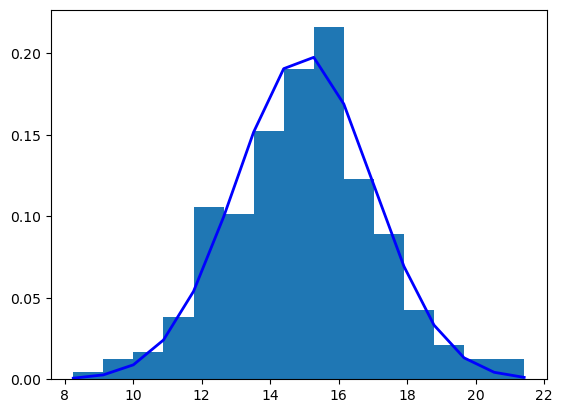

In [1024]:
# let's create a normal (standard) distribution with mean (mu) = 15, a standard deviation (sigma) = 2 
# and n representing every working day a year (n) = 365-(8*12)
# note that the choice of n is random, it could be 365 or any number representative (high enough)
mu, sigma, n = 15, 2, 365-(8*12)

dist = np.random.normal(mu, sigma, n)
count, bins, i = plt.hist(dist, 15, density=True)
plt.plot(bins, 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(bins-mu)**2/(2*sigma**2)),
         linewidth=2, color="blue")
plt.show()

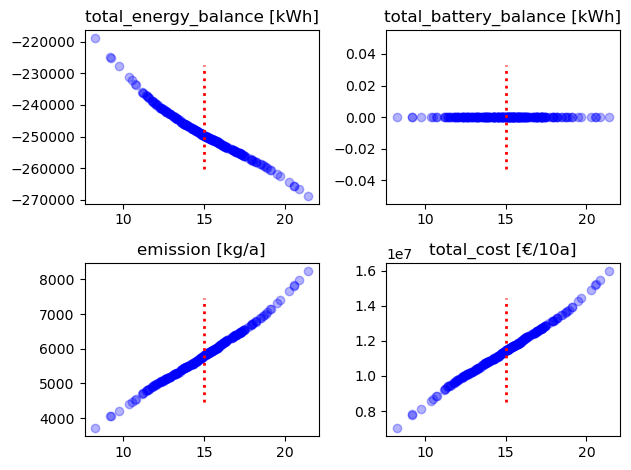

In [1038]:
# noisy avg_km_per_h model (pv_kWp = 100)
totein = []
toteout = []
totbch = []
totbdch = []
emis = []
cost = []
for i in dist:
    m.Etruck.avg_km_per_h = i
    randomness = simulate_pvb(trucks=fleet_trucks, battery_kWh=b_kWh, pv_kWp=100)
    totein.append(round(randomness.total_energy_input, 1))
    toteout.append(round(randomness.total_energy_output, 1))
    totbch.append(round(randomness.total_battery_charge, 1))
    totbdch.append(round(randomness.total_battery_discharge, 1))
    emis.append(round(randomness.emissions, 1))
    cost.append(round(randomness.total_cost, 1))

# plot
fig, ax = plt.subplots(2, 2)
ax[0,0].scatter(dist, [a - b for a, b in zip(toteout, totein)], color = "blue", alpha=.3)
ax[0,0].set_title("total_energy_balance [kWh]")
ax[0,0].axvline(x=15, ymin=0.2, ymax=0.8, linewidth=2, color="red", ls=":")
ax[0,1].scatter(dist, [a - b for a, b in zip(totbch, totbdch)], color = "blue", alpha= .3)
ax[0,1].set_title("total_battery_balance [kWh]")
ax[0,1].axvline(x=15, ymin=0.2, ymax=0.8, linewidth=2, color="red", ls=":")
ax[1,0].scatter(dist, emis, color = "blue", alpha = .3)
ax[1,0].set_title("emission [kg/a]")
ax[1,0].axvline(x=15, ymin=0.2, ymax=0.8, linewidth=2, color="red", ls=":")
ax[1,1].scatter(dist, cost, color = "blue", alpha=.3)
ax[1,1].set_title("total_cost [€/10a]")
ax[1,1].axvline(x=15, ymin=0.2, ymax=0.8, linewidth=2, color="red", ls=":")
fig.tight_layout()
plt.show()

***AnSWERs***: 
- Note that the vertical dotted red line represents the mean average km per hour (15 km/h).
- An decreasing  linear relationship between total energy balance and increasing average km per hour can be obtained from the top left figure. The negative values on the y axis indicate more overall energy input compared to the energy output. 
- As expected, an irrelevant (no effect) relationship between total battery balance and increasing average km per hour can be seen in the top right graph. The battery is always charged after it had gotten discharged during the truck's offsite mission.
- An increasing  linear relationship between emission and increasing average km per hour is revealed in the bottom left figure.
- An increasing  linear relationship between total cost and increasing average km per hour can be obtained from the bottom right grapgh.


### More Schedules

Energy Flows: 
Grid                 10224.0
PV to Truck          32946.0
PV to Battery       100587.0
PV to Grid           72060.0
Battery to Truck    100587.0
Grid to Truck        10224.0
Driven             -143757.0
dtype: float64
PV Yield: 205593kWh/a
self.system_cost=747_000.0€
self.operating_cost=2_451.6€/a
self.emissions=2760.4kg/a
self.self_consumption=0.8kWh
self.total_cost=771_516.2€/10a
self.load_cycles=67kwh

Energy Flows: 
Grid                   547.0
PV to Truck              1.0
PV to Battery       119131.0
PV to Grid           86461.0
Battery to Truck    119075.0
Grid to Truck          547.0
Driven             -120024.0
dtype: float64
PV Yield: 205593kWh/a
self.system_cost=747_000.0€
self.operating_cost=-583_046.6€/a
self.emissions=147.8kg/a
self.self_consumption=1.0kWh
self.total_cost=-5_083_466.4€/10a
self.load_cycles=79kwh

Energy Flows: 
Grid                  1359.0
PV to Truck          12670.0
PV to Battery        96282.0
PV to Grid          135059.0
Battery to Truck

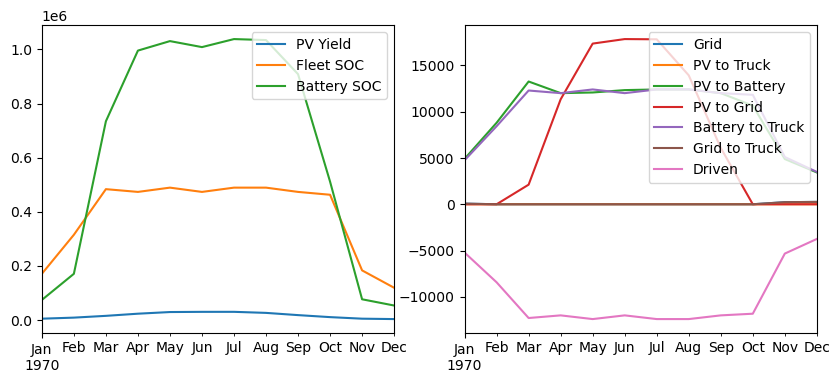

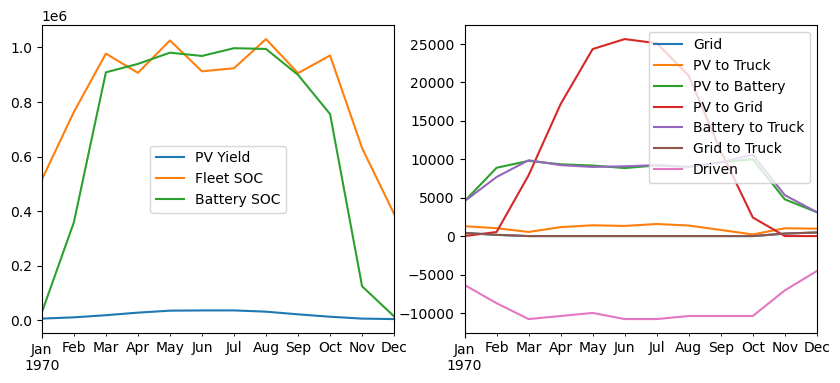

In [1026]:
# def status() in Model.py has to be modified accordingly

pw_kWo = 198 # of base model
dayt = simulate_pvb(trucks=np.repeat([m.Etruck(schedule="daytime")], 7).tolist(), 
                               pv_kWp=pw_kWo, 
                               battery_kWh=1500)
even = simulate_pvb(trucks=np.repeat([m.Etruck(schedule="evening")], 7).tolist(), 
                               pv_kWp=pv_kWo, 
                               battery_kWh=1500)
print(results01_pvb)
print(dayt)
print(even)
dayt.visualize(("M", "M"))
even.visualize(("M", "M"))

In [1029]:
# every possible combination of a fleet of 7 trucks:
import itertools as it
sched_combo = list(it.combinations_with_replacement([m.Etruck(schedule="workday"),
                                                    m.Etruck(schedule="worknight"),
                                                    m.Etruck(schedule="daytime"),
                                                    m.Etruck(schedule="nighttime"),
                                                    m.Etruck(schedule="evening"),
                                                    m.Etruck(schedule="lunchbreak")], 7))
len(sched_combo) # There are 792 combinations.

# loop over possible combinations with a pv_kWp=198 constant
op_munk = []
sched_munk = []
for i in sched_combo:
    sim_res = simulate_pvb(trucks=i, pv_kWp=198, battery_kWh=1500)
    op_munk.append(sim_res.operating_cost)
    sched_munk.append(sim_res.total_cost)
    
# eliminate negative operating (and total) costs
op_munk = np.array(op_munk)
sched_munk = np.array(sched_munk)
sched_munki = sched_munk[np.where(op_munk>0)]
sched_combo = np.array(sched_combo)
sched_combo = sched_combo[np.where(op_munk>0)]

print(f"Optimal fleet composition:\n {sched_combo[np.argmin(sched_munki)]},\n revealing a total costs of {round(sched_munki[np.argmin(sched_munki)], 1)} €/10a.")

Optimal fleet composition:
 [Etruck(schedule='workday') Etruck(schedule='workday')
 Etruck(schedule='workday') Etruck(schedule='workday')
 Etruck(schedule='workday') Etruck(schedule='workday')
 Etruck(schedule='nighttime')],
 revealing a total costs of 776664.3 €/10a.


***AnSWERs***: 
- Operating costs became negative in the cases of a "daytime" and "evening" models compared to the base model, becasue there is a clear PV to Grid overload (top and bottom right figures). The Grid does not get rid of the energy, this phenomenon is represented by the negative operating and accordingly total costs. This issue could be remedied by adjusting either default parameter combinations of
``` 
    grid_tarif_cpkWh = 50
    grid_feedin_cpkWh = 7.06
```
or 
``` 
    battery_kWh
    pv_kWp
```
A combined `optimization` of these parameters could improve the model for the "daytime" and "evening" scheduled truck fleet.
- Optimal fleet composition consits of 6 "workday" and 1 "nighttime" scheduled trucks, its total cost revealed by the iterative search simulation is 776664.3 €/10a.

### Sensitivity Analysis

In [1030]:
# default parameters:
# default Battery SoC to zero
# pv_cost_pkWp = 1500
# battery_kWh: float
# battery_cost_pkWh= 300
# grid_tarif_cpkWh = 50
# grid_feedin_cpkWh = 7.06

# let's define sensible ranges:
# keep Battery SoC at default (zero)
# pv_cost_pkWp = 1000, 1500, 2000        (Result_pvb)
# battery_kWh = 100, 150, 200            (simulate_pvb())  
# battery_cost_pkWh = 250, 300, 350      (Result_pvb)
# grid_tarif_cpkWh = 0.19, 25, 50        (Result_pvb)
# grid_feeding_cpkWh = 0.05, 3.55, 7.06  (Result_pvb)

# pv_kWp will be kept at 100
pv_kWo = 100

# Result_pvb parameters are represented on simulate_pcb() method level,
# they can be modified by selecting any Result_pvb.'parameter', for example:
# Result_pvb.grid_feedin_cpkWh = 0.05
# one can check whether its modified values is assigned:
# simulate_pvb().grid_feedin_cpkWh

# set of Result_pvb parameter ranges:
pv_cost = [1000, 1500, 2000]
batt_cost = [250, 300, 350]
grid_tarif = [0.19, 25, 50]
grid_feeding = [0.05, 3.55, 7.06]
# battery_kWh:
batt_kWh = [1000, 1500, 2000]

# empty data frame with column names:
#data = []
#for i, ii, iii in zip(pv_cost, batt_cost, grid_tarif):
#    data.append([i, ii, iii])

#df = pd.DataFrame(data, columns=["numbers", "batt_cost", "grid_tarif"])

# every possible parameter combination:
import itertools as it

combo = []
for i in it.product(pv_cost, batt_cost, grid_tarif, grid_feeding, batt_kWh):
    combo.append(i)

df = pd.DataFrame(combo, columns = ["pv_cost", "batt_cost", "grid_tarif", "grid_feeding", "batt_kWh"])
df.index = np.arange(0,np.shape(df)[0],1)

# a fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

# empty list for collecting total_cost values
tc = []

# iteration within a loop
for i in df.index:
    Result_pvb.pv_cost_pkWp = df.loc[i, "pv_cost"]
    Result_pvb.battery_cost_pkWh = df.loc[i, "batt_cost"]
    Result_pvb.grid_tarif_cpkWh = df.loc[i, "grid_tarif"]
    Result_pvb.grid_feedin_cpkWh = df.loc[i, "grid_feeding"]
    res = simulate_pvb(trucks=fleet_trucks, battery_kWh= df.loc[i, "batt_kWh"], pv_kWp=pv_kWo)
    tc.append(round(res.total_cost, 1))

# add tc to data frame
df["total_cost"] = tc
df

,pv_cost,batt_cost,grid_tarif,grid_feeding,batt_kWh,total_cost
0,1000,250,0.19,0.05,1000,395415.3
1,1000,250,0.19,0.05,1500,521193.3
2,1000,250,0.19,0.05,2000,646165.4
3,1000,250,0.19,3.55,1000,358963.2
4,1000,250,0.19,3.55,1500,519239.0
...,...,...,...,...,...,...
238,2000,350,50.00,3.55,1500,12886508.8
239,2000,350,50.00,3.55,2000,13048789.6
240,2000,350,50.00,7.06,1000,12645445.2
241,2000,350,50.00,7.06,1500,12884548.8


ID ~ Parameter combinations of:
 ['pv_cost' 'batt_cost' 'grid_tarif' 'grid_feeding' 'batt_kWh']

>>>>> ID: 0 >>>>>
 pv_cost         1000.00
batt_cost        250.00
grid_tarif         0.19
grid_feeding       0.05
batt_kWh        1000.00
Name: 0, dtype: float64

>>>>> ID: 1 >>>>>
 pv_cost         1000.00
batt_cost        250.00
grid_tarif         0.19
grid_feeding       0.05
batt_kWh        1500.00
Name: 1, dtype: float64

>>>>> ID: 2 >>>>>
 pv_cost         1000.00
batt_cost        250.00
grid_tarif         0.19
grid_feeding       0.05
batt_kWh        2000.00
Name: 2, dtype: float64

>>>>> ID: 3 >>>>>
 pv_cost         1000.00
batt_cost        250.00
grid_tarif         0.19
grid_feeding       3.55
batt_kWh        1000.00
Name: 3, dtype: float64

>>>>> ID: 4 >>>>>
 pv_cost         1000.00
batt_cost        250.00
grid_tarif         0.19
grid_feeding       3.55
batt_kWh        1500.00
Name: 4, dtype: float64

>>>>> ID: 5 >>>>>
 pv_cost         1000.00
batt_cost        250.00
grid_tarif      

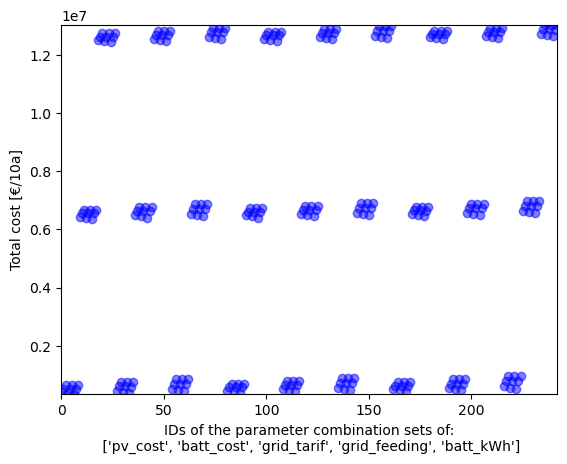

Minimum total cost is:
322102.1 €/10a
revealed by
pv_cost         1000.00
batt_cost        250.00
grid_tarif         0.19
grid_feeding       7.06
batt_kWh        1000.00
Name: 6, dtype: float64 
parameter combination sets.


In [1031]:
# param combo IDs
print(f"ID ~ Parameter combinations of:\n {np.array(df.columns[0:5])}")
for i in range(0, df.shape[0]):
    print(f"\n>>>>> ID: {i} >>>>>\n {df.loc[i, df.columns[0:5]]}")

# plot
plt.scatter(df.index, df["total_cost"], color = "blue", alpha = .5)
plt.ylabel("Total cost [€/10a]")
plt.xlabel(f"IDs of the parameter combination sets of:\n {df.columns[0:5].tolist()}")
plt.xlim([df.index[0], df.index[-1]])
plt.ylim([min(df["total_cost"]), max(df["total_cost"])])
plt.show()

# obtaining optimal model (minimum total_cost)
min_tc = df["total_cost"][np.argmin(df["total_cost"])]
params = df[df.columns[0:5]].loc[np.argmin(df["total_cost"])]
print(f"Minimum total cost is:\n{min_tc} €/10a\nrevealed by\n{params} \nparameter combination sets.")

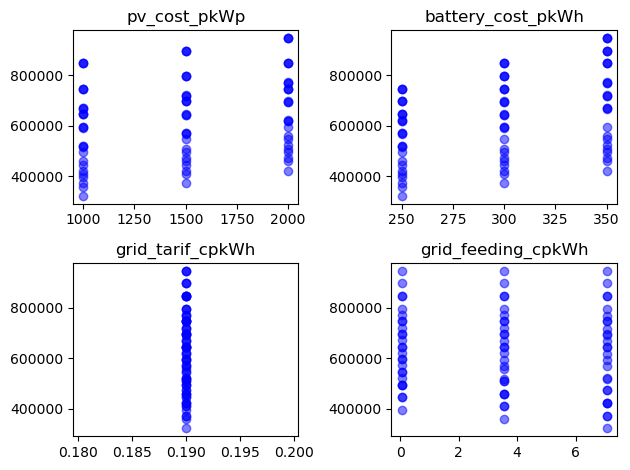

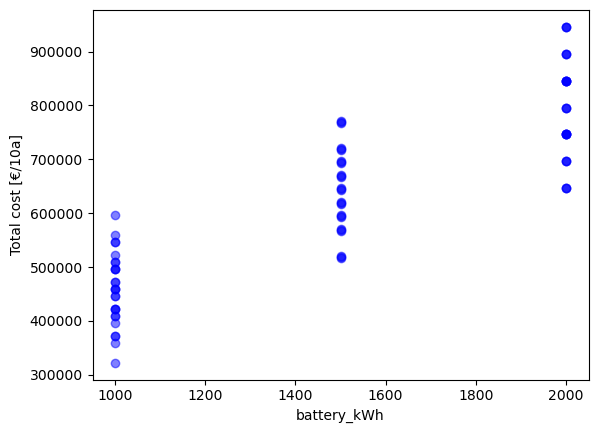

81

In [1036]:
# let's take a look at the lowest price class, under 1000000 €/10a total costs
df_under2m = df[df.columns[0:6]].loc[df["total_cost"] < 1000000]

# plot
fig, ax = plt.subplots(2, 2)
ax[0,0].scatter(df_under2m["pv_cost"], df_under2m["total_cost"], color = "blue", alpha = .5)
ax[0,0].set_title("pv_cost_pkWp")
ax[0,1].scatter(df_under2m["batt_cost"], df_under2m["total_cost"], color = "blue", alpha = .5)
ax[0,1].set_title("battery_cost_pkWh")
ax[1,0].scatter(df_under2m["grid_tarif"], df_under2m["total_cost"], color = "blue", alpha = .5)
ax[1,0].set_title("grid_tarif_cpkWh")
ax[1,1].scatter(df_under2m["grid_feeding"], df_under2m["total_cost"], color = "blue", alpha = .5)
ax[1,1].set_title("grid_feeding_cpkWh")
fig.tight_layout()
plt.show()

plt.scatter(df_under2m["batt_kWh"], df_under2m["total_cost"], color = "blue", alpha = .5)
plt.ylabel("Total cost [€/10a]")
plt.xlabel("battery_kWh")
plt.show()

df_under2m.shape[0]

***AnSWERs***: 
- The total costs of 81 parameter combination sets are under 1000000 €/10a. They are displayed in an aggregated fashion as can be seen in the figure above. Apparently, two parameters *grid_tarif_ckpWh* and *battery_kWh* are the most influential in total cost reduction. While the former one (*grid_tarif_cpkWh*) is by far the most influential, being responsible for the aggregation on the y axis (total cost) in three price groups: under 1 million, between 6 and 7 millions and around 11 and 12 millions €/10a.
- Differentiation within price groups are mainly defined by the *battery_kWh* parameter. The rest of the parameters are less influential. Increasing *grid_feeding* parameter value has a negative effect on total cost compared to the other parameters (they raise the total cost).
- The lowest total cost 322102.1 €/10a was obtained by the following parameter combination set:
```
pv_cost_pkWp          1000.00
battery_cost_pkWh      250.00
grid_tarif_cpkWh         0.19
grid_feeding_cpkWh       7.06
battery_kWh           1000.00
```
making it the optimal candidate for realizing a fleet of trucks (with 5 "workday" and 2 "worknight" trucks) with pv, battery and grid. Note, that the schedule variants of the trucks were not included in the sensitivity analysis, the inclusion of this parameter would be the next step towards a more advanced analysis. 

### Monthly Schedule 

In [14]:
###~~~~~~~~~~~~~~~~~~~~~~~~
# Base model functionality
###~~~~~~~~~~~~~~~~~~~~~~~~
import numpy as np
import pandas as pd
import Model as m
import matplotlib.pyplot as plt
###~~~~~~~~~~~~~~~~~~~~~~~~

# Result_pvb for simulate_pvb():
class Result_pvb:
    energy_balance: pd.DataFrame
    states: pd.DataFrame
    pv_kWp: float
    pv_cost_pkWp = 1500                    # was 1000
    battery_kWh: float                     # was float
    battery_cost_pkWh= 300                 # was 300
    grid_tarif_cpkWh = 50                  # was 0.19
    grid_feedin_cpkWh = 7.06               # was 0.05
    co2_intensity = 0.270                  # kg/kWh grid
    trucks: list

    @property
    def system_cost(self):
        return self.pv_cost_pkWp*self.pv_kWp + self.battery_cost_pkWh*self.battery_kWh
    
    #> Operating cost per annum? >
    @property
    def operating_cost(self):
        return self.energy_balance["Grid to Truck"].sum()*self.grid_tarif_cpkWh - self.energy_balance["PV to Grid"].sum()*self.grid_feedin_cpkWh
    
    @property
    def emissions(self):
        return self.energy_balance["Grid to Truck"].sum()*self.co2_intensity
    
    #> Self-consumption from "PV to Grid" to "PV to Truck" >
    @property
    def self_consumption(self):
        return 1-(self.energy_balance["PV to Truck"].sum()/self.states["PV Yield"].sum())
    
    @property
    def fleet_capacity(self):
        return sum(truck.capacity_kWh for truck in self.trucks)
    
    #> Total cost for 10 years >
    @property
    def total_cost(self):
        return self.system_cost + self.operating_cost * 10 

    #> Load-cycles battery charge >
    @property
    def load_cycles(self):
        total_charge = self.total_battery_charge
        return total_charge / self.battery_kWh  
    
    #> extension from Übung 3:
    @property
    def total_battery_charge(self):
        return self.energy_balance["PV to Battery"].sum()

    @property
    def total_battery_discharge(self):
        return self.energy_balance["Battery to Truck"].sum()

    @property
    def total_energy_input(self):
        return self.energy_balance[["PV to Truck", "Battery to Truck", "Grid to Truck"]].sum().sum()

    @property
    def total_energy_output(self):
        return self.energy_balance["Driven"].sum()

    def check_battery_balance(self):
        total_charge = self.total_battery_charge
        total_discharge = self.total_battery_discharge
        print(f"Total Battery Charge: {total_charge:.2f} kWh")
        print(f"Total Battery Discharge: {total_discharge:.2f} kWh")
        if total_charge == total_discharge:
            print(">>>> ___Battery Charge = Battery Discharge___ <<<<\n")
        elif total_charge > total_discharge:
            print(">>>> ___Battery charge > Battery Discharge___ <<<<\n")
        else:
            print(">>>> ___Battery charge < Battery Discharge___ <<<<\n")

    def check_energy_balance(self):
        total_input = self.total_energy_input
        total_output = self.total_energy_output
        if total_output < 0:
            total_output = abs(total_output)
        print(f"Total Energy Input: {total_input:.2f} kWh")
        print(f"Total Energy Output from Trucks: {total_output:.2f} kWh")
        if total_input == total_output:
            print(">>>> ___Energy Input = Energy Output___ <<<<\n")
        elif total_input > total_output:
            print(">>>> ___Energy Input > Energy Output___ <<<<\n")
        else:
            print(">>>> ___Energy Input < Energy Output___ <<<<\n")
    #>>>>> until here
    
    def visualize(self, resample=(None, None)):
        states, energy_balance = self.states, self.energy_balance
        fig, ax = plt.subplots(1,2, figsize=(10,4))
        if resample[0] is not None:
            states = states.resample(resample[0]).sum()
        if resample[1] is not None:
            energy_balance = energy_balance.resample(resample[1]).sum()
        states.plot(ax=ax[0])
        energy_balance.plot(ax=ax[1])

    #> extension from Übung 3:    
        self.check_battery_balance()
        self.check_energy_balance()
    #>>>>> until here

    def __repr__(self):
        string = f"Energy Flows: \n{self.energy_balance.sum().round()}"
        string += f'\nPV Yield: {self.states["PV Yield"].sum().round():.0f}kWh/a'
        string += f"\n{self.system_cost=:_.1f}€"
        string += f'\n{self.operating_cost=:_.1f}€/a'                               
        string += f'\n{self.emissions=:.1f}kg/a'
        string += f'\n{self.self_consumption=:.1f}kWh'                              # added
        string += f'\n{self.total_cost=:_.1f}€/10a'                                 # added
        string += f'\n{self.load_cycles=:.0f}kwh\n'                                 # added
        return string
    
#> 1) >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
#> simulaion pv, battery and grid included >
def simulate_pvb(
        csv_dpath = "D:\Maria\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                  # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

In [15]:
# "Convert this info in an average km goal per truck per hour per month and use this list to..."
# dynamically set the km driven depending on the month. 

# a fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

# amount of work hours per month of a "workday" truck
wdhh = (24-3)*5*4*5  # working hours a day * working day * number of weeks a month * 5 "workday" trucks

# amount of work hours per month for a "worknight" truck
wnhh = (24-12)*5*4*2  # working hours a day * working day * number of weeks a month * 2 "worknight" trucks

# "daytime"
dth = (24-3)*7*4

# "nighttime"
nth = (24-12)*7*4

# "evening"
evh = (24-3)*5*4

# "lunchbreak"
lbh = (24-(6+5))*7*4

ft = [str(a) for a in fleet_trucks]

wdh = (24-3)*5*4*np.sum(["workday" in a for a in ft])
wnh = (24-12)*5*4*np.sum(["worknight" in a for a in ft])
dth = (24-3)*7*4*np.sum(["daytime" in a for a in ft])
nth = (24-12)*7*4*np.sum(["nighttime" in a for a in ft])
evh = (24-3)*5*4*np.sum(["evening" in a for a in ft])
lbh = (24-(6+5))*7*4*np.sum(["lunchbreak" in a for a in ft])

# cheking
avg_km = 36750/(wdh+wnh+dth+nth+evh+lbh)
avg_km

avg_kmm = 36750/(wdhh+wnhh)
avg_kmm == avg_km

True

In [16]:
# add monthly_km hidden (inside the function) parameter via list_monthly_km parameter to simulate_pvb()
def simulate_pvbm(
        csv_dpath = "D:\SimMod_E-Post\data\PV_1kWp.csv",
        start_day = 0, 
        hours=8760, 
        trucks = [m.Etruck(schedule="workday")],
        pv_kWp = 200,
        battery_kWh = 2000,
        list_monthly_km = list,                   # added 
        grid_threshold = 0.2):
    
    start_hour = start_day * 24
    stop_hour = start_hour + hours
    pv_raw = pv_kWp*np.genfromtxt(csv_dpath)/1000  # -> Wh > kWh/h
    pv = pv_raw[start_hour:stop_hour]
    
    battery = m.Battery()
    battery.capacity_kWh = battery_kWh
    battery.current_kWh = 0                   # This what was meant by setting default Battery SOC to 0

    energy_balance = pd.DataFrame()
    energy_balance.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]
    states = pd.DataFrame()
    states.index = np.arange(start=0, stop=8760, dtype="datetime64[h]")[start_hour:stop_hour]

    current_kWh = np.zeros(hours)
    current_kWh[0] = sum(truck.current_kWh for truck in trucks)
    battery_SOC_kWh = np.zeros(hours)

    gridcharge_kWh = np.zeros(hours)          # Grid > truck
    pvcharge_kWh = np.zeros(hours)            # PV > Truck
    battery_to_truck_kWh = np.zeros(hours)    # battery > Truck
    pv_to_battery_kWh = np.zeros(hours)
    pv_to_grid_kWh = np.zeros(hours)
    driven_kWh = np.zeros(hours)

    for h in range(hours):
        i = energy_balance.index[h]
        hd = i.hour
        wd = i.weekday()
        mo = i.month                          # added iterative month 

        dispatchable_PV = pv[h]
        for truck in trucks:
            if truck.status(hd, wd) == "onsite":
                pv_used_in_truck = truck.charge(dispatchable_PV)
                pvcharge_kWh[h] += pv_used_in_truck
                dispatchable_PV -= pv_used_in_truck

                batt_used_in_truck = truck.charge(battery.max_discharge)
                battery.discharge(batt_used_in_truck)
                battery_SOC_kWh[h] -= batt_used_in_truck
                battery_to_truck_kWh[h] += batt_used_in_truck
                
                if truck.SoC < grid_threshold:
                    difference_kWh = (grid_threshold - truck.SoC)*truck.capacity_kWh
                    gridcharge_kWh[h] += truck.charge(difference_kWh)
            
            if truck.status(hd, wd) == "offsite":
                
                # select appropiate month (use iterative mo = i.month)              # added monthly_km
                monthly_km = list_monthly_km[mo-1]
                # dynamic avg_km_per_h                                              
                ft = [str(a) for a in trucks]

                wdh = (24-3)*5*4*np.sum(["workday" in a for a in ft])
                wnh = (24-12)*5*4*np.sum(["worknight" in a for a in ft])
                dth = (24-3)*7*4*np.sum(["daytime" in a for a in ft])
                nth = (24-12)*7*4*np.sum(["nighttime" in a for a in ft])
                evh = (24-3)*5*4*np.sum(["evening" in a for a in ft])
                lbh = (24-(6+5))*7*4*np.sum(["lunchbreak" in a for a in ft])

                avg_km = monthly_km/(wdh+wnh+dth+nth+evh+lbh)
                truck.avg_km_per_h = avg_km
                # until here
                
                driven_kWh[h] += truck.discharge(truck.avg_km_per_h*truck.consumption)
                
            current_kWh[h] += truck.current_kWh
        
        pv_to_battery_kWh[h] = battery.charge(dispatchable_PV)
        pv_to_grid_kWh[h] = dispatchable_PV - pv_to_battery_kWh[h]
        battery_SOC_kWh[h] = battery.current_kWh
    
    states["PV Yield"] = pv
    states["Fleet SOC"] = current_kWh
    states["Battery SOC"] = battery_SOC_kWh
    energy_balance["Grid"] = gridcharge_kWh
    energy_balance["PV to Truck"] = pvcharge_kWh
    energy_balance["PV to Battery"] = pv_to_battery_kWh
    energy_balance["PV to Grid"] = pv_to_grid_kWh
    energy_balance["Battery to Truck"] = battery_to_truck_kWh
    energy_balance["Grid to Truck"] = gridcharge_kWh
    energy_balance["Driven"] = -driven_kWh

    results = Result_pvb()

    results.energy_balance = energy_balance
    results.states = states
    results.battery_kWh = battery_kWh
    results.pv_kWp = pv_kWp
    results.trucks = trucks

    return results

In [17]:
# base truck fleet of 7 trucks
fleet_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 5), 
                               np.repeat([m.Etruck(schedule="worknight")], 2))).tolist()

# optimized truck fleet
fleet_opti_trucks = np.concatenate((np.repeat([m.Etruck(schedule="workday")], 6), 
                                    np.repeat([m.Etruck(schedule="evening")], 1))).tolist()

# Compare these two schedules for the
# base truck fleet and one with an optimizied schedule:
km1 = [57800, 51850, 56100, 53550, 55250, 54400, 54400, 52700, 51000, 57800, 55250, 57800]
km2 = [36750, 39000, 70100, 69000, 78700, 65100, 75200, 66000, 69400, 64500, 60000, 35200]

# simulate base truck leet
msim_base_km1 = simulate_pvbm(trucks=fleet_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km1)
msim_base_km2 = simulate_pvbm(trucks=fleet_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km2)

# simulate optimized truck fleet
msim_opti_km1 = simulate_pvbm(trucks=fleet_opti_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km1)
msim_opti_km2 = simulate_pvbm(trucks=fleet_opti_trucks, pv_kWp=200, battery_kWh=1500, list_monthly_km=km2)


Energy Flows: 
Grid                 16796.0
PV to Truck          51265.0
PV to Battery       105120.0
PV to Grid           51284.0
Battery to Truck    105120.0
Grid to Truck        16796.0
Driven             -173981.0
dtype: float64
PV Yield: 207669kWh/a
self.system_cost=750_000.0€
self.operating_cost=477_747.9€/a
self.emissions=4535.0kg/a
self.self_consumption=0.8kWh
self.total_cost=5_527_478.9€/10a
self.load_cycles=70kwh

Total Battery Charge: 105119.74 kWh
Total Battery Discharge: 105119.74 kWh
>>>> ___Battery charge < Battery Discharge___ <<<<

Total Energy Input: 173181.33 kWh
Total Energy Output from Trucks: 173981.33 kWh
>>>> ___Energy Input < Energy Output___ <<<<

Energy Flows: 
Grid                 15762.0
PV to Truck          53757.0
PV to Battery       108418.0
PV to Grid           45495.0
Battery to Truck    108418.0
Grid to Truck        15762.0
Driven             -177893.0
dtype: float64
PV Yield: 207669kWh/a
self.system_cost=750_000.0€
self.operating_cost=466_896.2€/a
se

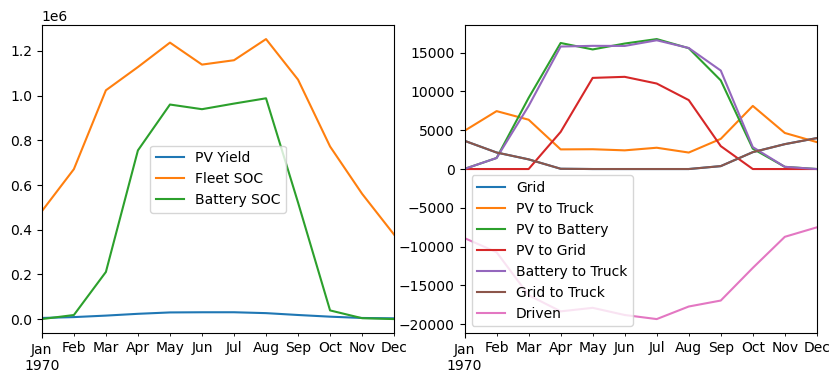

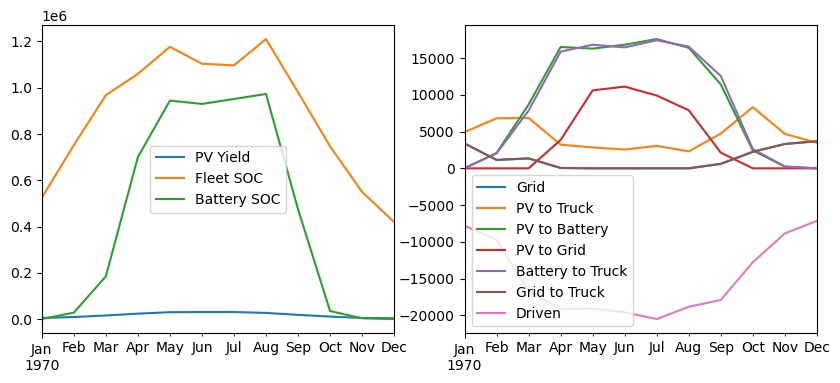

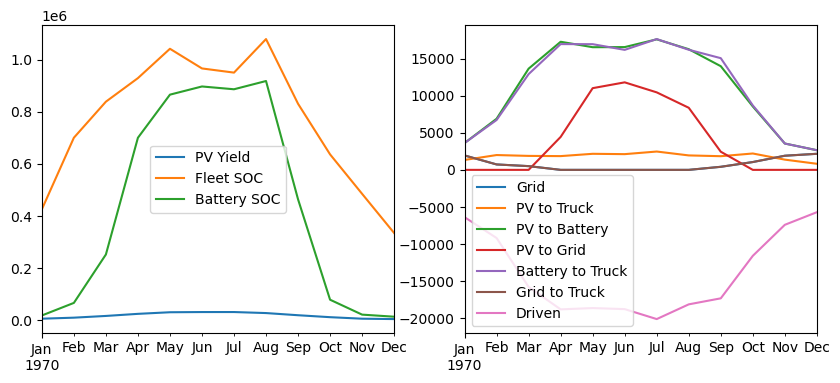

In [18]:
# print and visualize
print(msim_base_km1)
msim_base_km1.visualize(("M", "M"))
print(msim_base_km2)
msim_base_km2.visualize(("M", "M"))
print(msim_opti_km2)
msim_opti_km2.visualize(("M", "M"))

***AnSWERs***: 
- Unexpectedly, there can be observed almost no differences between 'km1' and 'km2' base models. As shown above, their similarities are highlighted quantitatively and graphically as well (top and middle figures).
- Regarding the optimized model (note that only the 'km2' model was considered) (bottom figure), it revealed a total cost of 1858664.8 €/10a which is less than the half of the base models, 5782478.9 and 5593962.4 €/10a respectively. Thus, it is safe to conclude that our optimized model is well-optimized.
- -> Overall, the effects of the two varying km per h per month lists ~ as compared to each other ~, are negligible. The optimized model outperforms the base models. It is not necessary to check 'km1' with optimized model, since it is very likely similar to the optimized model using 'km2' list. -> Let's not let curiosity kill the cat, let's quickly plot it below.

Energy Flows: 
Grid                  8625.0
PV to Truck          20691.0
PV to Battery       126387.0
PV to Grid           60591.0
Battery to Truck    126387.0
Grid to Truck         8625.0
Driven             -156490.0
dtype: float64
PV Yield: 207669kWh/a
self.system_cost=925_000.0€
self.operating_cost=3_496.3€/a
self.emissions=2328.9kg/a
self.self_consumption=0.9kWh
self.total_cost=959_962.8€/10a
self.load_cycles=84kwh

Total Battery Charge: 126387.22 kWh
Total Battery Discharge: 126387.22 kWh
>>>> ___Battery charge > Battery Discharge___ <<<<

Total Energy Input: 155703.55 kWh
Total Energy Output from Trucks: 156490.39 kWh
>>>> ___Energy Input < Energy Output___ <<<<



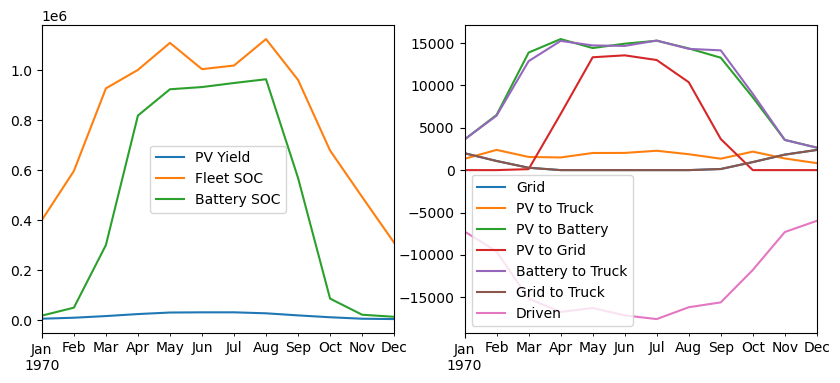

In [1041]:
print(msim_opti_km1)
msim_opti_km1.visualize(("M", "M"))

In [1042]:
print(f"Standarad deviation of 'km1': {round(np.std(km1), 0)}")
print(f"Standarad deviation of 'km2': {round(np.std(km2), 0)}")

Standarad deviation of 'km1': 2208.0
Standarad deviation of 'km2': 14504.0


***CONCLUSIONs***: 
- Well, we were wrong, Battery SOC is closer to the Fleet SOC! Moreover, the 'km1' optimised model reduced the total cost to 959962.8 €/10a, to the half of the total cost obtained by 'km2' optimized model. 
- -> Once the parameter set optimized, it DOES MATTER how average km goal per truck per hour per month  is distributed over the months of year. Since 'km1' evidences much less standard deviation, 2208 vs. 14504 km, it is recommended to keep the target km per month (accordingly the obtained average km goal per truck per hour) steady, close to the mean, with not much standard deviation (variabilty).